In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.interpolate as itplt

## Use 100 points for interpolation. Use points in between for testing

In [2]:
n=4
m=5
x_train = np.linspace(-np.pi/2, np.pi/2, n+m + 1)
y_train = np.cos(x_train)
### Use half-interval test set
x_min = x_train[2]
x_max = x_train[-3]
x_test = (np.linspace(x_min, x_max, 101))
y_test = np.cos(x_test)

Using 20 points as the original data

Similar to the code Prof. Sievers used in class for demonstration, a polynomial going through point $x_j$ while being zero at all other $x_{i}$ is simply $\text{poly}_{j}=\prod_{j}(x-x_{i})/\prod_{i}(x_{j}-x_{i})$.
To get a polynomial which goes through all $x_{j}$'s, we can simply do $\sum_{j}\text{poly}_{j}y_j$.

### Because I do not know how to vectorize the code, I have to evaluate each point of interpolation individually

In [3]:
def poly_interp(x, y, x_eval):
    order = len(x)
    
    y_eval = np.zeros(len(x_eval))
    
    for i, ex in enumerate(x_eval):
        for j in np.arange(order): 
            xx = np.hstack([x[:j],x[j + 1:]])
            xj = x[j]
            yj = y[j]
            norm = np.prod(x[j] - xx)
            ## this is equivalent to evaluating the polynomial, which is unity at x[j], at ex,
            ## and dividing by the normalization
            eval_j = np.prod(ex - xx)*yj/norm
            ## Because polynomial interpolation is linear in each polynomial centered at x[j], 
            ## we add the contributions to get interpolated values
            y_eval[i] += eval_j
        
    return y_eval
        

In [4]:
def cubic_spline(x, y, x_eval):
    spln = itplt.splrep(x,y)
    y_eval = itplt.splev(x_eval, spln)
    return y_eval

In [34]:
def rational_fit(num_order, x, y, x_eval, return_coef=False):
    n = num_order
    m= len(y) - 1 - n #denominator order
    print(m)

    pcols=[x**k for k in range(n+1)]
    pmat=np.vstack(pcols)

    qcols=[-x**k*y for k in range(1, m+1)]
    qmat=np.vstack(qcols)
    mat=np.hstack([pmat.T,qmat.T])
    coeffs=np.linalg.inv(mat)@y

    p=0
    for i in range(n+1):
        p += coeffs[i]*x_eval**i
        
    qq=1
    for i in range(m):
        qq += coeffs[n+1+i]*x_eval**(i+1)
    
    if return_coef==False:
        return p/qq
    else:
        return p/qq, coeffs
    


#### and the psudo-inverse rational interp... for later use

In [44]:
def psudo_rat_int(num_order, x, y, x_eval, return_coef=False):
    n = num_order
    m= len(y) - 1 - n #denominator order
    print(m)

    pcols=[x**k for k in range(n+1)]
    pmat=np.vstack(pcols)

    qcols=[-x**k*y for k in range(1, m+1)]
    qmat=np.vstack(qcols)
    mat=np.hstack([pmat.T,qmat.T])
    coeffs=np.linalg.pinv(mat)@y

    p=0
    for i in range(n+1):
        p += coeffs[i]*x_eval**i
        
    qq=1
    for i in range(m):
        qq += coeffs[n+1+i]*x_eval**(i+1)
    
    if return_coef==False:
        return p/qq
    else:
        return p/qq, coeffs

# COSINE interpolation

5


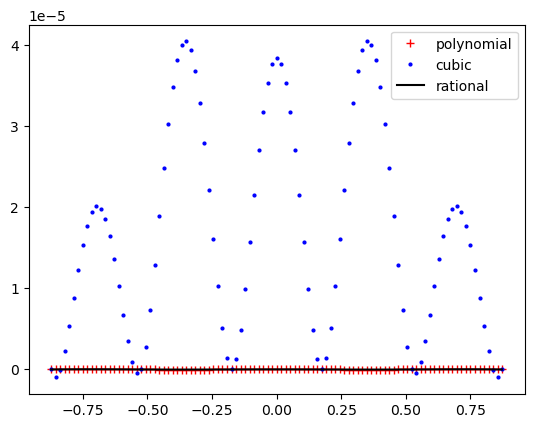

In [6]:
y_poly = poly_interp(x_train, y_train, x_test)
y_cubic = cubic_spline(x_train,y_train, x_test)
y_rat = rational_fit(n, x_train, y_train, x_test)


err_poly = y_test - y_poly
err_cubic = y_test - y_cubic
err_rat = y_test - y_rat

# plt.plot(x_train, y_train, 'ko', ms = 1)
# plt.plot(x_test, y_eval, 'r+')
plt.plot(x_test, err_poly, 'r+',label = "polynomial")
plt.plot(x_test, err_cubic, 'bo', ms = 2, label = "cubic" )
plt.plot(x_test, err_rat, 'k-', ms = 2, label = "rational",zorder = 10)
plt.legend()

m_poly = np.mean(np.abs(err_poly))
m_cubic = np.mean(np.abs(err_cubic))
m_rat = np.mean(np.abs(err_rat))
s_poly = np.std(np.abs(err_poly))
s_cubic = np.std(np.abs(err_cubic))
s_rat = np.std(np.abs(err_rat))

In [7]:
print(f"Poly fit: {m_poly:.2E} +/- {s_poly:.2E}")
print(f"Cubic fit: {m_cubic:.2E} +/- {s_cubic:.2E}")
print(f"Rational fit: {m_rat:.2E} +/- {s_rat:.2E}")

Poly fit: 6.36E-09 +/- 4.09E-09
Cubic fit: 1.66E-05 +/- 1.31E-05
Rational fit: 9.77E-09 +/- 6.18E-09


Seems like both the polynomial and rational fits are doing the best job. Now try this on a Lorentzian.
Knowing that the denominator is a second order polynomial, we set the "m" order parameter to 2 for the rational function

# LORENTZIAN interpolation

In [8]:
def lor(x):
    return 1/(1+x**2)

Generate a total of n+m+1 points for the matrix inside "rational_interp" to be square.

Polynomial and spline computes the order from length of the input

### Error for the rational function fit
Since if we set p(x)/qq(x) = y(x), and set n=0, we can fit to the Lorentizan exactly since it is a rational function. 

Any residual error should be due to numerical precision, not from the Taylor series.
As can be seen below, average $\varepsilon$ for the rational interpolation is on the order of 1E-16.

In [64]:
n=0
m=6

x_train = np.linspace(-1, 1, n+m + 1)
y_train = lor(x_train)
### Use half-interval test set
x_test = np.linspace(x_train.min(), x_train.max(), 1001)
y_test = lor(x_test)

6


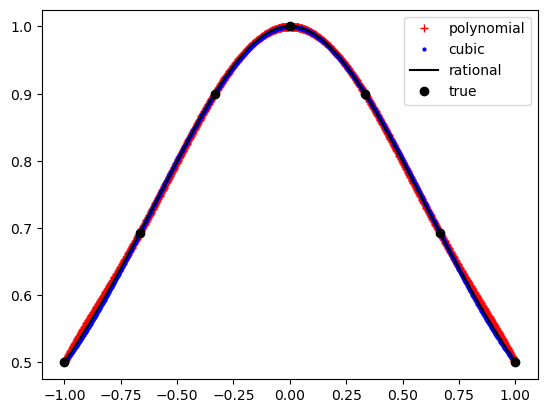

In [65]:
y_poly = poly_interp(x_train, y_train, x_test)
y_cubic = cubic_spline(x_train,y_train, x_test)
y_rat = rational_fit(n, x_train, y_train, x_test)

err_poly = y_test - y_poly
err_cubic = y_test - y_cubic
err_rat = y_test - y_rat


plt.plot(x_test, y_poly, 'r+',label = "polynomial")
plt.plot(x_test, y_cubic, 'bo', ms = 2, label = "cubic" )
plt.plot(x_test, y_rat, 'k-', ms = 2, label = "rational",zorder = 10)
plt.plot(x_train, y_train, 'ko',label = 'true')
plt.legend()


m_poly = np.mean(np.abs(err_poly))
m_cubic = np.mean(np.abs(err_cubic))
m_rat = np.mean(np.abs(err_rat))
s_poly = np.std(np.abs(err_poly))
s_cubic = np.std(np.abs(err_cubic))
s_rat = np.std(np.abs(err_rat))

In [66]:
print(f"Poly fit: {m_poly:.2E} +/- {s_poly:.2E}")
print(f"Cubic fit: {m_cubic:.2E} +/- {s_cubic:.2E}")
print(f"Rational fit: {m_rat:.2E} +/- {s_rat:.2E}")

Poly fit: 1.68E-03 +/- 2.11E-03
Cubic fit: 1.31E-03 +/- 1.02E-03
Rational fit: 2.45E-16 +/- 1.63E-16


### Higher order Lorentzian
Let's try n=4, m=5

In [93]:
n=5
m=5

x_train = np.linspace(-1, 1, n+m + 1)
y_train = lor(x_train)
### Use half-interval test set
x_test = np.linspace(x_train.min(), x_train.max(), 1001)
y_test = lor(x_test)

5


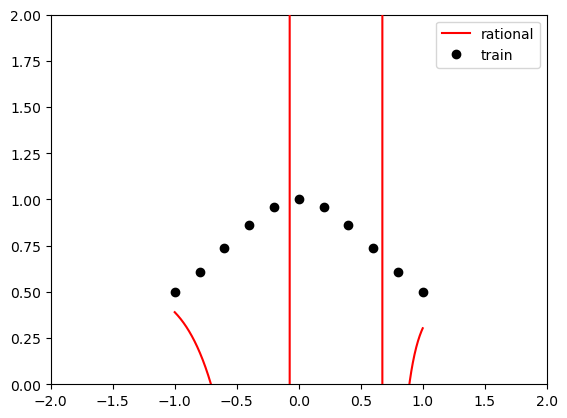

In [94]:
y_poly = poly_interp(x_train, y_train, x_test)
y_cubic = cubic_spline(x_train,y_train, x_test)
y_rat, coeffs = rational_fit(n, x_train, y_train, x_test, True)

err_poly = y_test - y_poly
err_cubic = y_test - y_cubic
err_rat = y_test - y_rat

plt.axis([-2,2,0,2])
# plt.plot(x_test, y_poly, 'r+',label = "polynomial")
# plt.plot(x_test, y_cubic, 'bo', ms = 1, label = "cubic" )
plt.plot(x_test, y_rat, 'r-', ms = 1, label = "rational",zorder = 10)
plt.plot(x_train, y_train, 'ko',label = 'train')

plt.legend()


m_poly = np.mean(np.abs(err_poly))
m_cubic = np.mean(np.abs(err_cubic))
m_rat = np.mean(np.abs(err_rat))
s_poly = np.std(np.abs(err_poly))
s_cubic = np.std(np.abs(err_cubic))
s_rat = np.std(np.abs(err_rat))

This is not what I expected. I should examine the fitted coefficients. Ideally, we should get:
[1, 0,0,0, 0; 0,1,0,0,0] = [p;q]

In [96]:
coeffs

array([ 15.308501  ,   9.4375    , -24.125     ,  -9.8125    ,
         1.64318583,   2.47858052,  12.9375    , -10.75      ,
        -7.90625   , -10.5       ,  -1.5       ])

Well well... This is probably due to some funny buisiness computing the **matrix inverse**, assuming our code structure is right.

5


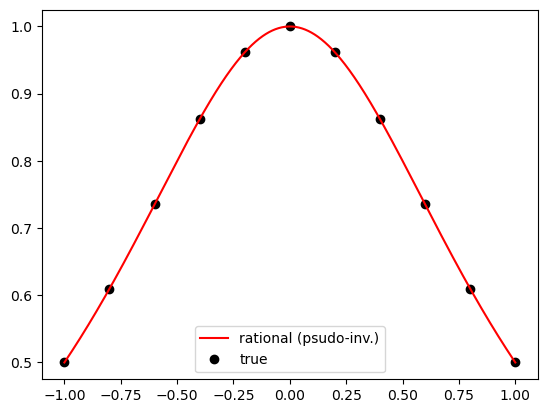

In [97]:
y_rat2, coeffs2 = psudo_rat_int(n, x_train, y_train, x_test, True)

err_rat2 = y_test - y_rat2

plt.plot(x_test, y_rat2, 'r-', ms = 2, label = "rational (psudo-inv.)",zorder = 10)
plt.plot(x_train, y_train, 'ko',label = 'true')
plt.legend()

m_rat2 = np.mean(np.abs(err_rat2))
s_rat2 = np.std(np.abs(err_rat2))

In [98]:
coeffs2

array([ 1.00000000e+00, -6.88338275e-15, -3.33333333e-01,  8.88178420e-15,
        7.10542736e-15, -1.24344979e-14, -9.65894031e-15,  6.66666667e-01,
        1.59872116e-14, -3.33333333e-01, -2.88657986e-14])

$Ax = \lambda x$ for an eigenvector of x. When we invert the matrix, the eigenvalue becomes $1/\lambda x$. For a singular matrix, eigenvalue for the whole kernel is 0. However, because of machine precision, when we apply matrix inverse on these vectors, the vectors magnitude becomes much larger, which is why the coefficients were large when we used `np.linalg.inv`.

In the case of `np.linalge.inv`, it *Calculate the generalized inverse of a matrix using its singular-value decomposition (SVD) and including all large singular values*. By limiting ourselves to large eigenvalues in the original matrix, we solve for small coefficients of `p,q` that fits our input `x,y`.
